# HomeWork 2

Подготовить валидацию с использованием фреймворка RecTools. Работаем с датасетом Kion

Важно! Разработанный функционал будет использоваться вами на протяжении всего курса, это ваш основной инструмент для валидации всех моделей, которые вы будете изучать.

Задача: разработать две функции (по желанию можно реализовать классами) - одна для расчёта метрик на основе кросс-валидации и одна для визуального анализа рекомендаций.

### Расчёт метрик (5 баллов)

#### Функция будет принимать на вход:
    1.1 Словарь с инициализированными моделями
    1.2 Словарь с инициализированными метриками
    1.3 Инициализированный Splitter для кросс-валидации
    1.4 Количество рекомендаций для генерации (K)

#### Реализация обучения и валидации:
    1.1 Создаем RecTools Dataset через метод construct на train взаимодействиях для каждого фолда
    1.2 Обучаем модель (не забываем сделать deepcopy), рекоменуем K айтемов для каждого юзера, считаем метрики на test
    1.3 Дополнительно логируем время обучения
    1.4 Сохраняем метрики в отчёт
    Результат оборачиваем в pandas DataFrame и усредняем по фолдам

### Визуальный анализ (5 баллов)

#### Функция будет принимать на вход:
    1.1 Инициализированную (и обученную!) модель
    1.2 Датасет
    1.3 Список отобранных user_id для просмотра
    1.4 item_data - данные об айтемах, которые важно отразить для визуального анализа (напр. название)

#### Реализация:
    1.1 Генерим рекомендации для отобранных user_id
    1.2 Получаем из датасета истории просмотров юзеров
    1.3 Отображаем в любом удобном виде, который позволит смотреть на историю просмотра юзера + на его рекомендации от модели

### Для тестирования функций используем:

#### Модели: 
    - rectools.models.RandomModel(random_state=32), 
    - rectools.models.PopularModel() с параметрами по умолчанию  
    
##### Метрики: 
    - 2 ранжирующие,  
    - 2 классификационные,  
    - 2 beyond-accuracy.  
    - Считаем по порогам 1, 5, 10. MAP обязательно   
    Сплиттер: rectools.model_selection.TimeRangeSplitter,  
    - 3 фолда для кросс-валидации по неделе  
    - исключение холодных юзеров и айтемов и просмотренных айтемов  
    
    Визуализация рекомендаций и историй просмотров для юзеров [666262, 672861, 955527].  
    Для айтемов обязательно отражаем названия, жанры и количество просмотров  датасете (как для айтемов из истории взаимодействий каждого юзера, так и для айтемов из его рекомендаций)  

Весь результат в одном чистом, воспроизводимом jupyter ноутбуке

In [1]:
import pandas as pd
import numpy as np

#!pip install rectools
#!pip install seaborn
#!pip install pyarrow
# !pip install Jinja2

In [2]:
inter = pd.read_csv(
    "../data/interactions.csv",
)

items = pd.read_csv(
    '../data/items.csv',
)

# users = pd.read_csv(
#     '../data/users.csv',
# )

# EDA

In [3]:
inter.head(3)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [4]:
inter.shape

(5476251, 5)

In [5]:
inter.groupby(["user_id", "item_id"])["total_dur"].count().reset_index().sort_values(ascending=False, by="total_dur")

,user_id,item_id,total_dur
0,0,6006,1
3650840,732072,12318,1
3650838,732072,3804,1
3650837,732072,3343,1
3650836,732071,15297,1
...,...,...,...
1825416,366421,14317,1
1825415,366421,13865,1
1825414,366421,13243,1
1825413,366421,13159,1


### Определил нельзя переагрегировать матрицу
- 1 юзер соотвествует 1 итему

In [6]:
inter = inter.rename(columns={"last_watch_dt": "datetime"})

inter["datetime"] = pd.to_datetime(inter["datetime"])

inter["weight"] = inter["total_dur"] * inter["watched_pct"]
# inter['weight'] = np.where(inter['watched_pct'] > 25, 1, 0) * inter['total_dur']

### Распределение фичи watched_pct
- Вероятно большинство пользователей скипают фильмы в первое время

<Axes: xlabel='watched_pct', ylabel='Density'>

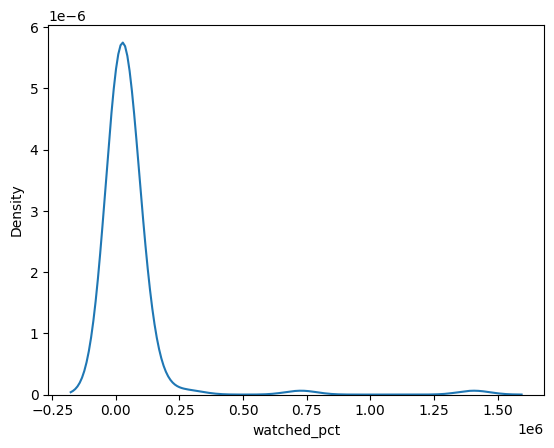

In [7]:
import seaborn as sns

sns.kdeplot(inter["watched_pct"].value_counts())

<Axes: xlabel='weight', ylabel='Density'>

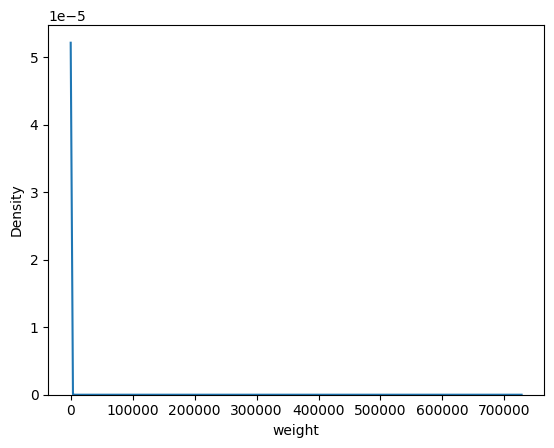

In [8]:
sns.kdeplot(inter["weight"].value_counts())

### Количество уникальных юзеров в день

<Axes: xlabel='datetime', ylabel='user_id'>

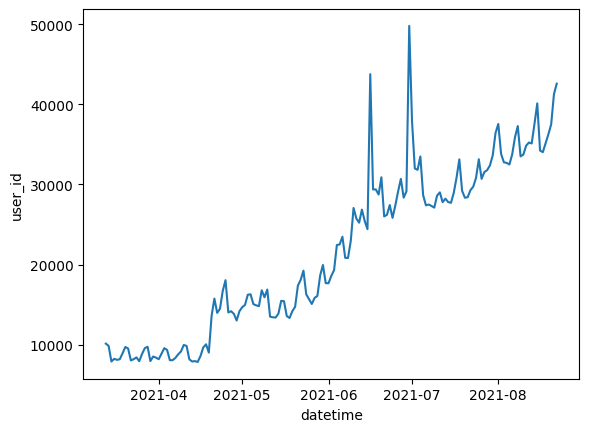

In [9]:
sns.lineplot(data=inter.groupby("datetime")["user_id"].nunique().reset_index(), x="datetime", y="user_id")

# Задание 1

In [10]:
from rectools.metrics import (
    Precision,
    Recall,
    NDCG,
    MAP,
    Serendipity,
    MeanInvUserFreq,
    calc_metrics,
)

from rectools.models import RandomModel, PopularModel
from rectools import Columns
from rectools.model_selection.time_split import TimeRangeSplitter
from rectools.dataset import Interactions, Dataset

/home/kartushov/pet_projects/itmo/itmo.recsys/RecoServiceTemplate/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kartushov/pet_projects/itmo/itmo.recsys/RecoServiceTemplate/.venv/lib/python3.10/site-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [11]:
K = 10

n_splits = 3

splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

models = {
    "random": RandomModel(random_state=42),
    "popular": PopularModel(),
}

metrics = {
    "MAPTop-1": MAP(k=1),
    "MAPTop-5": MAP(k=5),
    "MAPTop-10": MAP(k=10),
    "NDCG@1": NDCG(k=1),
    "NDCG@5": NDCG(k=5),
    "NDCG@10": NDCG(k=10),
    "Precision@1": Precision(k=1),
    "Precision@5": Precision(k=5),
    "Precision@10": Precision(k=10),
    "Recall@1": Recall(k=1),
    "Recall@5": Recall(k=5),
    "Recall@10": Recall(k=10),
    "Novelty@1": MeanInvUserFreq(k=1),
    "Novelty@5": MeanInvUserFreq(k=5),
    "Novelty@10": MeanInvUserFreq(k=10),
    "Serendipity": Serendipity(k=1),
    "Serendipity": Serendipity(k=5),
    "Serendipity": Serendipity(k=10),
}


In [28]:
import time
import pickle
from tqdm import tqdm


class RecSysModule:
    def __init__(
        self, model_dict: dict = None, metrics_dict: dict = None, splitter: TimeRangeSplitter = None, k: int = 10
    ):
        """
        Initialize the RecSysModule object.

        Parameters
        ----------
        model_dict : dict, optional
            Dictionary containing models, by default None
        metrics_dict : dict, optional
            Dictionary containing metrics, by default None
        splitter : TimeRangeSplitter, optional
            TimeRangeSplitter object for splitting data, by default None
        k : int, optional
            Value of 'k' for top-k recommendations, by default 10

        Raises
        ------
        ValueError
            If splitter is not provided.
        ValueError
            If metrics_dict is not provided.
        ValueError
            If model_dict is not provided.
        ValueError
            If no metrics are provided.
        ValueError
            If no models are provided.
        ValueError
            If k is negative.
        """
        if splitter is None:
            raise ValueError("Please provide splitter")
        if metrics_dict is None:
            raise ValueError("Please provide metrics_dict")
        if model_dict is None:
            raise ValueError("Please provide model_dict")
        if len(metrics_dict) == 0:
            raise ValueError("Please provide at least one metric")
        if len(model_dict) == 0:
            raise ValueError("Please provide at least one model")
        if k < 0:
            raise ValueError("k cannot be negative")

        self.model_dict = model_dict
        self.metrics_dict = metrics_dict
        self.splitter = splitter
        self.k = k

    def evaluate(self, interaction: pd.DataFrame) -> pd.DataFrame:
        results = []

        fold_iterator = self.splitter.split(interaction, collect_fold_stats=True)
        if len(self.splitter.get_test_fold_borders(interaction)) < 1:
            raise ValueError("Please provide at least one test fold")
        
        for train_ids, test_ids, fold_info in tqdm((fold_iterator), total=n_splits):
            start_time = time.time()

            train = interaction.df.iloc[train_ids]
            test = interaction.df.iloc[test_ids][Columns.UserItem]

            dataset = Dataset.construct(train)
            test_users = np.unique(test[Columns.User])
            catalog = train[Columns.Item].unique()

            for model_name, model in models.items():
                model.fit(dataset)
                
                with open(f'../models/{model_name}_{fold_info["i_split"]}.pickle', 'wb') as f:
                    pickle.dump(model, f)

                recos = model.recommend(
                    users=test_users,
                    dataset=dataset,
                    k=self.k,
                    filter_viewed=True,
                )
                metric_values = calc_metrics(
                    metrics,
                    reco=recos,
                    interactions=test,
                    prev_interactions=train,
                    catalog=catalog,
                )
                end_time = time.time()
                evaluation_time = end_time - start_time

                res = {"fold": fold_info["i_split"], "model": model_name, "evaluation_time": evaluation_time}
                res.update(metric_values)
                results.append(res)

        self.metrics_result = results

    def visualize_results(self):
            pivot_results = pd.DataFrame(self.metrics_result).drop(columns="fold").groupby(["model"], sort=False).agg(["mean", "std"])
            mean_metric_subset = [(metric, agg) for metric, agg in pivot_results.columns if agg == 'mean']
            return (
                pivot_results.style
                .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
                .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
            )

    def visualize_analysis(self, model, dataset, user_ids, item_data):
        recos = model.recommend(users=user_ids, dataset=dataset, k=self.k, filter_viewed=True)
        recos = recos[recos[Columns.User].isin(user_ids)]
        recos = recos.merge(item_data, on=[Columns.Item], how='left')[['title', 'genres', Columns.User, Columns.Item]]
        
        history = dataset.interactions.df
        history = history[history[Columns.User].isin(user_ids)]
        history = history.merge(item_data, on=[Columns.Item], how='left')[['title', 'genres', Columns.User, Columns.Item]]

        for user in user_ids:
            print(f"User {user} history:")
            history_items = history[Columns.Item].unique()
            print(f"Total count views user: {history[Columns.Item].nunique()}")
            for item in history_items:
                _his_item_dataset = dataset.interactions.df
                item_title = history[history[Columns.Item] == item]['title'].values[0]
                # unique equal count cuz 1 user ~ 1 item in this set
                item_unviews = _his_item_dataset[_his_item_dataset[Columns.Item] == item][Columns.User].nunique()
                print(f"{item_title} | total views: {item_unviews}")
            display(history[history[Columns.User] == user])
            print()
            print(f"User {user} recommendations:")
            display(recos[recos[Columns.User] == user])
            print()
            print()

In [29]:
interactions = Interactions(inter)

recsys = RecSysModule(
    model_dict=models,
    metrics_dict=metrics,
    splitter=splitter,
    k=10,
)

In [14]:
recsys.evaluate(interactions)

100%|██████████| 3/3 [01:11<00:00, 23.94s/it]


In [15]:
recsys.visualize_results()

In [30]:
with open('../models/popular_0.pickle', 'rb') as f:
    random_model = pickle.load(f)

users2test = [666262, 672861, 955527]

dataset = Dataset.construct(inter)

recsys.visualize_analysis(
    random_model,
    dataset=dataset,
    user_ids=users2test,
    item_data=items,
)

User 666262 history:
Total count views user: 4
Дом ночных призраков | total views: 68581 | nunique users: 68581
Медвежонок Винни и его друзья | total views: 202457 | nunique users: 202457
В ритме сердца | total views: 132865 | nunique users: 132865
Признание 5 | total views: 193123 | nunique users: 193123


,title,genres,user_id,item_id
0,Дом ночных призраков,"зарубежные, криминал, детективы, ужасы",666262,93



User 666262 recommendations:


,title,genres,user_id,item_id
0,Хороший человек,"драмы, триллеры",666262,2616
1,Непосредственно Каха,комедии,666262,1819
2,Воскресший Эртугрул,"боевики, драмы, приключения",666262,496
3,Ещё одна из рода Болейн,"драмы, мелодрамы",666262,3190
4,Бездомный Бог,"аниме, фэнтези, приключения, комедии",666262,11505
5,На пятьдесят оттенков темнее,"драмы, мелодрамы",666262,11143
6,Родные,"драмы, комедии",666262,3071
7,Два брата,"драмы, семейное, приключения",666262,7135
8,Дочь,драмы,666262,7026
9,Злодей,"боевики, драмы, триллеры",666262,2043




User 672861 history:
Total count views user: 4
Дом ночных призраков | total views: 68581 | nunique users: 68581
Медвежонок Винни и его друзья | total views: 202457 | nunique users: 202457
В ритме сердца | total views: 132865 | nunique users: 132865
Признание 5 | total views: 193123 | nunique users: 193123


,title,genres,user_id,item_id
1,Медвежонок Винни и его друзья,"мюзиклы, мультфильм, приключения, комедии",672861,25
2,В ритме сердца,"драмы, мюзиклы, мелодрамы",672861,32



User 672861 recommendations:


,title,genres,user_id,item_id
10,Хороший человек,"драмы, триллеры",672861,2616
11,Непосредственно Каха,комедии,672861,1819
12,Воскресший Эртугрул,"боевики, драмы, приключения",672861,496
13,Ещё одна из рода Болейн,"драмы, мелодрамы",672861,3190
14,Бездомный Бог,"аниме, фэнтези, приключения, комедии",672861,11505
15,На пятьдесят оттенков темнее,"драмы, мелодрамы",672861,11143
16,Родные,"драмы, комедии",672861,3071
17,Два брата,"драмы, семейное, приключения",672861,7135
18,Дочь,драмы,672861,7026
19,Злодей,"боевики, драмы, триллеры",672861,2043




User 955527 history:
Total count views user: 4
Дом ночных призраков | total views: 68581 | nunique users: 68581
Медвежонок Винни и его друзья | total views: 202457 | nunique users: 202457
В ритме сердца | total views: 132865 | nunique users: 132865
Признание 5 | total views: 193123 | nunique users: 193123


,title,genres,user_id,item_id
3,Признание 5,для взрослых,955527,21



User 955527 recommendations:


,title,genres,user_id,item_id
20,Хороший человек,"драмы, триллеры",955527,2616
21,Непосредственно Каха,комедии,955527,1819
22,Воскресший Эртугрул,"боевики, драмы, приключения",955527,496
23,Ещё одна из рода Болейн,"драмы, мелодрамы",955527,3190
24,Бездомный Бог,"аниме, фэнтези, приключения, комедии",955527,11505
25,На пятьдесят оттенков темнее,"драмы, мелодрамы",955527,11143
26,Родные,"драмы, комедии",955527,3071
27,Два брата,"драмы, семейное, приключения",955527,7135
28,Дочь,драмы,955527,7026
29,Злодей,"боевики, драмы, триллеры",955527,2043


In [31]:
with open('../models/random_0.pickle', 'rb') as f:
    random_model = pickle.load(f)

users2test = [666262, 672861, 955527]

dataset = Dataset.construct(inter)

recsys.visualize_analysis(
    random_model,
    dataset=dataset,
    user_ids=users2test,
    item_data=items,
)

User 666262 history:
Total count views user: 4
Дом ночных призраков | total views: 68581 | nunique users: 68581
Медвежонок Винни и его друзья | total views: 202457 | nunique users: 202457
В ритме сердца | total views: 132865 | nunique users: 132865
Признание 5 | total views: 193123 | nunique users: 193123


,title,genres,user_id,item_id
0,Дом ночных призраков,"зарубежные, криминал, детективы, ужасы",666262,93



User 666262 recommendations:


,title,genres,user_id,item_id
0,Ода радости,комедии,666262,7419
1,Последняя битва,"драмы, военные",666262,9109
2,Преисподняя,"драмы, детективы, триллеры, вестерн",666262,13917
3,Лихорадка,ужасы,666262,13332
4,Вечность,драмы,666262,1331
5,Леший,"триллеры, криминал, детективы",666262,15448
6,Богема,"драмы, мюзиклы, мелодрамы",666262,1123
7,Шедевр,"драмы, комедии",666262,9933
8,Единоборства для детей (3-6 лет) Школа героев ...,"единоборства, фитнес, для детей",666262,3287
9,Американский пирог: Все в сборе,комедии,666262,8478




User 672861 history:
Total count views user: 4
Дом ночных призраков | total views: 68581 | nunique users: 68581
Медвежонок Винни и его друзья | total views: 202457 | nunique users: 202457
В ритме сердца | total views: 132865 | nunique users: 132865
Признание 5 | total views: 193123 | nunique users: 193123


,title,genres,user_id,item_id
1,Медвежонок Винни и его друзья,"мюзиклы, мультфильм, приключения, комедии",672861,25
2,В ритме сердца,"драмы, мюзиклы, мелодрамы",672861,32



User 672861 recommendations:


,title,genres,user_id,item_id
10,Джек: Путь смерти,"боевики, зарубежные, триллеры, криминал",672861,1483
11,Фиаско,комедии,672861,11062
12,Песня Любви (субтитры),"драмы, мелодрамы",672861,12863
13,Палата,"зарубежные, триллеры, ужасы",672861,15487
14,Перспектива (с тифлокомментарием),"фантастика, драмы, зарубежные, триллеры",672861,1818
15,Красотка,"мелодрамы, комедии",672861,14809
16,Смешарики.Легенда о золотом драконе,"мультфильм, приключения, комедии",672861,8207
17,Тихоокеанский рубеж 2,"боевики, фантастика, приключения",672861,8799
18,Расти-механик,"семейное, для детей",672861,14725
19,Учим математику с Ам Нямом,"русские, для детей, развитие, сериалы",672861,11960




User 955527 history:
Total count views user: 4
Дом ночных призраков | total views: 68581 | nunique users: 68581
Медвежонок Винни и его друзья | total views: 202457 | nunique users: 202457
В ритме сердца | total views: 132865 | nunique users: 132865
Признание 5 | total views: 193123 | nunique users: 193123


,title,genres,user_id,item_id
3,Признание 5,для взрослых,955527,21



User 955527 recommendations:


,title,genres,user_id,item_id
20,"Леопард, великолепная способность к адаптации....",документальное,955527,11405
21,Творение Господне,"драмы, биография, фильмы hbo",955527,14305
22,Мусульмане как мы,документальное,955527,7720
23,Проклятие ведьмы снов,"зарубежные, фантастика, триллеры, боевики, ужа...",955527,1212
24,Искусство путешествовать,"зарубежные, приключения",955527,8485
25,Мозаика,"драмы, детективы",955527,12234
26,Мороз по коже,мелодрамы,955527,12862
27,Класс коррекции,драмы,955527,6604
28,Договор молчания,"триллеры, детективы",955527,5291
29,Третья волна зомби,"фантастика, зарубежные, драмы, ужасы",955527,6538
